In [1]:
import subprocess
import os
import time

In [2]:
# Variables block for papermill
num_gpus = 8
x_start = 20000
x_span = 20000
x_step = 4000
y_start = 32000
y_span = 20000
y_step = 4000
z_start = 96
z_span = 16
z_step = 16

model_weights = "../output/bloss18_membrane_weights.npy"
output_dir = '../output/untracked/run1'
inference_notebook = './inference-bloss18.ipynb'

In [3]:
os.makedirs(os.path.join(output_dir, 'npy'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'png'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'ipynb'), exist_ok=True)

## Create list of cutouts to process

In [4]:
xx = x_start
yy = y_start
zz = z_start
start_list = list()
for x in range(x_start, x_start+x_span, x_step):
    for y in range(y_start, y_start+y_span, y_step):
        for z in range(z_start, z_start+z_span, z_step):
            start_list.append((x,y,z))
print(len(start_list))

25


## Process all blocks across all available GPUs

In [5]:
# gtm:ignore
current_procs = list()
job_cnt = 0
gpu_idxs = [x for x in range(num_gpus)]
while len(start_list) > 0 or len(current_procs) > 0:
    if len(current_procs) < num_gpus:
        if len(start_list) > 0:
            coord = start_list.pop()
            g = gpu_idxs.pop()
            print(f"starting job with GPU {g}")
            prefix = f"bloss18_membrane_z{coord[2]}-{coord[2]+z_span}_y{coord[1]}-{coord[1]+y_span}_x{coord[0]}-{coord[0]+x_span}"
            p = subprocess.Popen(["papermill", 
                                  inference_notebook,
                                  os.path.join(output_dir, 'ipynb', f"{prefix}.ipynb"),
                                  "-p", "x_start", str(coord[0]),
                                  "-p", "x_step", str(x_step),
                                  "-p", "y_start", str(coord[1]),
                                  "-p", "y_step", str(y_step),
                                  "-p", "z_start", str(coord[2]),
                                  "-p", "z_step", str(z_step),
                                  "-p", "weights_file", str(model_weights),
                                  "-p", "output_dir", str(output_dir),
                                  "-p", "file_prefix", str(prefix),
                                  "-p", "gpu_idx", str(g)
                                 ], 
                                 cwd=os.environ['PROJECT_CODE'],
                                 stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            current_procs.append((p, g))
            job_cnt += 1
            if job_cnt < 3:
                # ramp up data IO
                time.sleep(15)
    
    for idx, job in enumerate(current_procs):
        proc, gpu_idx = job
        status = proc.poll()
        if status == None:
            continue
        elif status == 0:
            print(f"Finished job with GPU {gpu_idx}")
            del current_procs[idx]
            gpu_idxs.append(gpu_idx)
        else:
            print("job failed")
            std_out, std_err = proc.communicate()
            print(std_out)
            print(std_err)
            del current_procs[idx]
            gpu_idxs.append(gpu_idx)
    

starting job with GPU 7
starting job with GPU 6
starting job with GPU 5
starting job with GPU 4
starting job with GPU 3
starting job with GPU 2
starting job with GPU 1
starting job with GPU 0
Finished job with GPU 7
starting job with GPU 7
Finished job with GPU 6
starting job with GPU 6
Finished job with GPU 2
starting job with GPU 2
Finished job with GPU 0
starting job with GPU 0
Finished job with GPU 5
starting job with GPU 5
Finished job with GPU 1
starting job with GPU 1
Finished job with GPU 3
starting job with GPU 3
Finished job with GPU 4
starting job with GPU 4
Finished job with GPU 6
starting job with GPU 6
Finished job with GPU 2
starting job with GPU 2
Finished job with GPU 3
starting job with GPU 3
Finished job with GPU 6
starting job with GPU 6
Finished job with GPU 2
starting job with GPU 2
Finished job with GPU 5
starting job with GPU 5
Finished job with GPU 0
starting job with GPU 0
Finished job with GPU 3
starting job with GPU 3
Finished job with GPU 1
starting job wit

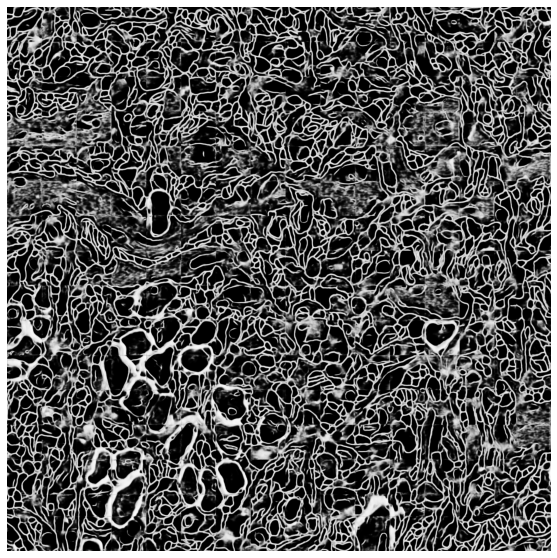

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
img = mpimg.imread("../output/untracked/run1/png/bloss18_membrane_z98_y40000-44000_x36000-40000.png");
plt.axis('off');
imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()